<a href="https://colab.research.google.com/github/GregoirePelletier/6.2M_chess_games/blob/main/ChessGaMes_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports
Imports the necessary libraries like pandas, chess, and chess.com API to work with chess game data, parse PGNs, and interface with the chess.com API.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from collections import OrderedDict, deque
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/drive')

## Data Gathering
Retrieves a list of top player usernames from the chess.com API. It then uses the API to collect the PGN data for past games played by each player on a month-by-month basis. The PGNs are parsed to extract the header and movelist data which is stored in a queue.

In [ ]:
!pip install python-chess
!pip install chess.com

In [ ]:
from io import StringIO
import chessdotcom as ch
from chess import pgn

ch.Client.request_config["headers"]["User-Agent"] = (
    "My Python Application. "
    "Contact me at email@example.com"
)

ch.Client.aio = True

In [ ]:
response = await ch.get_titled_players("GM")
gm_usernames = response.json["players"]
gm_usernames[:10]

['123lt',
 '124chess',
 '1977ivan',
 '1stsecond',
 '4thd-alpeacefulmoon',
 '731291',
 'a-adly',
 'a-fier',
 'abasovn',
 'abbasifarhassan']

### Scrapping Chess.com (⚠︎ discarded )
This section describes an initial discarded approach that tried to scrape game data directly from the chess.com website by generating HTTP requests. This proved to be unreliable due to page scraping limitations.

In [ ]:
import requests
from bs4 import BeautifulSoup

opening_name = "Caro-Kann Defense"
page_num = 4
r = requests.get(f'https://www.chess.com/games/search?opening={opening_name}&mr=2500&lsty=2&year=1900&lstMoves=2&moves=5&fen=&sort=&page={page_num}')
soup = BeautifulSoup(r.text, "html.parser")

In [ ]:
total_pages = int(soup.find(id = "master-games-container").get("data-total-pages"))

In [ ]:
soup.findAll(class_="cc-checkbox-input master-games-checkbox")

In [ ]:
checkboxes = soup.findAll(class_="cc-checkbox-input master-games-checkbox")
checkboxes[0]

In [ ]:
%%timeit
query_parameters = {"game_ids": ",".join(checkboxe.get("data-game-id") for checkboxe in checkboxes)}

In [ ]:
%%timeit
query_parameters = {"game_ids": ",".join(map(lambda checkboxe: checkboxe.get("data-game-id"), checkboxes))}

In [ ]:
game_ids = [checkboxe.get("data-game-id") for checkboxe in checkboxes]
game_urls = [f"https://www.chess.com/games/view/{id}" for id in game_ids]
query_parameters = {"game_ids": ",".join(game_ids)}

In [ ]:
url = "https://www.chess.com/games/downloadPgn"
r = requests.get(url, params=query_parameters)

In [ ]:
!pip install python-chess

In [ ]:
from io import StringIO
from collections import OrderedDict, deque
from chess import pgn
import pandas as pd

In [ ]:
%%timeit
games_pgn = StringIO(r.text)

i = 0
while (game := pgn.read_game(games_pgn)):
  game_dict = game.headers
  game_dict.update({"Opening": opening_name, "URL": game_urls[i], "Moves": str(game.mainline_moves())})
  game_df = pd.DataFrame([game_dict], columns=list(game_dict.keys()))

  if i == 0:
    df = game_df
    continue

  df = pd.concat([df, game_df])

  i += 1

In [ ]:
%%timeit
games_pgn = StringIO(r.text)

games = deque()

games_moves = r.text.split("\r\n\r\n")[1::3]
for game_url, game_moves in zip(game_urls, games_moves):
  game_dict = pgn.read_headers(games_pgn)
  game_dict.update({"Opening": opening_name, "URL": game_url, "Moves": games_moves[:-4]})
  games.append(game_dict)

df = pd.DataFrame(games, columns=game_dict.keys())

In [ ]:
def get_game_ids(content):
  soup = BeautifulSoup(content, "html.parser")
  checkboxes = soup.findAll(class_="cc-checkbox-input master-games-checkbox")
  return [checkboxe.get("data-game-id") for checkboxe in checkboxes]

In [ ]:
def get_games_pgn(game_ids):
  url = "https://www.chess.com/games/downloadPgn"
  query_parameters = {"game_ids": ",".join(game_ids)}
  r = requests.get(url, params=query_parameters)
  return r.text

In [ ]:
def append_games(games_pgn, games):
  games_pgn = StringIO(games_pgn)
  games_moves = r.text.split("\r\n\r\n")[1::3]
  for game_url, game_moves in zip(game_urls, games_moves):
    game_dict = pgn.read_headers(games_pgn)
    game_dict.update({"Opening": opening_name, "URL": game_url, "Moves": games_moves[:-4]})
    games.append(game_dict)

In [ ]:
import time
import random

In [ ]:
opening_name = "Sicilian Defense"
games = deque()
urls = [f'https://www.chess.com/games/search?opening={opening_name}&mr=2500&lstMoves=2&moves=5&fen=&sort=&page={page_num}' for page_num in range(1, 32)]
for url in urls:
  i = 1
  while not (response := requests.get(url, headers={"User-agent": "data-collector"})).ok:
    print(response.status_code)
    i *= 2
    time.sleep(i + random.random())

  print(response.status_code)

  game_ids = get_game_ids(response.text)
  games_pgn = get_games_pgn(game_ids)
  game_urls = [f"https://www.chess.com/games/view/{id}" for id in game_ids]
  query_parameters = {"game_ids": ",".join(game_ids)}

  games_pgn = StringIO(games_pgn)
  games_moves = r.text.split("\r\n\r\n")[1::3]
  for game_url, game_moves in zip(game_urls, games_moves):
    game_dict = pgn.read_headers(games_pgn)
    game_dict.update({"Opening": opening_name, "URL": game_url, "Moves": games_moves[:-4]})
    games.append(game_dict)

### Chess.com API
Implements an efficient approach to collect over a million games' metadata directly from the chess.com API. It loads GM usernames, then loops through retrieving monthly game data as PGNs from the API. Headers are parsed and games appended to a deque. On completion, data is saved to CSV files. Player statistics are also collected via API and stored.

In [ ]:
# Initialize variables and data structures
games = deque()  # Queue to store game data
year = 2024  # Starting year
month = 2  # Starting month
i = 0  # Counter for iterations

# Loop until a million games are collected
while len(games) < 1e6:
    # Iterate through each game username
    for gm_username in gm_usernames:
        # Retrieve player games for the specified month
        response = await ch.get_player_games_by_month_pgn(gm_username, year=str(year), month=str(month))
        content = response.json["pgn"]["pgn"]

        # Extract game moves
        games_moves = content.split("\n\n")[1::2]

        # Process each game's moves
        for game_moves in games_moves:
            game_dict = pgn.read_headers(StringIO(content))  # Parse game headers
            game_dict.update(Moves=game_moves[:-4])  # Add moves to the dictionary
            games.append(game_dict)  # Add game dictionary to the queue

        i += 1  # Increment counter

        # Print progress every 10 iterations
        if (i % 10) == 0:
            print(len(games))

    # Create DataFrame from collected games and save to CSV
    df = pd.DataFrame(games, columns=game_dict.keys())
    df = df.drop_duplicates(keep="first")
    df.to_csv(f"/content/drive/MyDrive/chessgames/chessgames_{year}-{month:02d}.csv")

    games.clear()  # Clear the queue for the next iteration

    # Update year and month for the next iteration
    month -= 1
    year += (month - 1) // 12
    month = (month - 1) % 12
    month += 1  # Adjust month to handle year changes

In [ ]:
# Initialize deque to store player statistics
players_stats = deque()

# Iterate through each game username
for gm_username in gm_usernames:
    # Retrieve player statistics
    response = await ch.get_player_stats(gm_username)
    # Add username to the statistics
    response.json["stats"].update(username=gm_username)
    # Append player statistics to deque
    players_stats.append(response.json["stats"])

    # Print progress every 10 players
    if (len(players_stats) % 10) == 0:
        print(len(players_stats))

# Convert player statistics to DataFrame and save to CSV
stats = pd.json_normalize(players_stats)
stats.to_csv(f"/content/drive/MyDrive/chessgames/players_stats.csv")

## Data preprocessing
The data preprocessing section takes in the raw game data scraped from Chess.com and stored in multiple CSV files in a directory. It reads in each CSV file, combines them into a single DataFrame using pd.concat(), and performs the following tasks:

- Identifies and drops constant columns that do not provide valuable
- information using df.nunique()
- Concatenates all game data DataFrames into a single DataFrame
- Cleans up datetime columns like Date and Time
- Drops duplicate rows
- Handles missing values

In [ ]:
# Path to the directory containing the CSV files
directory = '/content/drive/MyDrive/chessgames/'

# List all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.startswith("chessgames") and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through each CSV file, read it into a DataFrame, and append to the list
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, index_col=0, low_memory=False)
    dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

### Data cleaning
The data cleaning section takes a look at the cleaned DataFrame and identifies areas for further cleaning:

- Identifies constant columns that can be dropped
- Splits the TimeControl column into separate Time and Increment columns
- Splits the Date column into separate DateYear, DateMonth, DateDay columns
- Drops unnecessary columns
- Drops rows with missing values in key columns like Moves
- Removes any remaining duplicate rows

In [ ]:
df.head()

,Event,Site,Date,Round,White,Black,Result,CurrentPosition,Timezone,ECO,...,WhiteElo,BlackElo,TimeControl,Termination,StartTime,EndDate,EndTime,Link,Moves,Tournament
0,Live Chess,Chess.com,2023.12.21,-,1977Ivan,TimAina,0-1,8/5p2/pp2p3/3kP3/P4K2/8/8/8 w - -,UTC,A45,...,2733,2771,180,TimAina won by resignation,18:50:14,2023.12.21,18:56:25,https://www.chess.com/game/live/96923504899,1. d4 {[%clk 0:03:00]} 1... Nf6 {[%clk 0:02:59...,NaN
1,Live Chess,Chess.com,2023.12.21,-,TimAina,1977Ivan,0-1,r1r3k1/1p6/p2p1qp1/3P3p/3Q1Pn1/8/PP2BK2/R5R1 w...,UTC,A41,...,2763,2759,180,1977Ivan won by resignation,18:46:42,2023.12.21,18:50:22,https://www.chess.com/game/live/96923433745,1. d4 {[%clk 0:03:00]} 1... c6 {[%clk 0:02:58....,NaN
2,Live Chess,Chess.com,2023.12.30,-,1stSecond,deathadder96,0-1,8/6k1/8/1P3PP1/5K1p/7b/3P4/8 w - -,UTC,A13,...,2814,2809,180,deathadder96 won on time,11:35:20,2023.12.30,11:41:40,https://www.chess.com/game/live/97675202829,1. Nf3 {[%clk 0:03:00]} 1... e6 {[%clk 0:02:58...,NaN
3,Live Chess,Chess.com,2023.12.30,-,deathadder96,1stSecond,0-1,8/8/8/1Q2K3/2p5/3r4/1pk5/8 w - -,UTC,A67,...,2801,2822,180,1stSecond won on time,11:28:50,2023.12.30,11:35:26,https://www.chess.com/game/live/97674667953,1. d4 {[%clk 0:03:00]} 1... Nf6 {[%clk 0:03:00...,NaN
4,Live Chess,Chess.com,2023.12.30,-,1stSecond,deathadder96,0-1,rnb1kbnr/pppp1ppp/4p3/6q1/3P4/8/PPP1PPPP/RN1QK...,UTC,A40,...,2814,2809,180,deathadder96 won by resignation,11:28:57,2023.12.30,11:29:04,https://www.chess.com/game/live/97674664491,1. d4 {[%clk 0:03:00]} 1... e6 {[%clk 0:02:58....,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393643 entries, 0 to 1393642
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Event            1393643 non-null  object
 1   Site             1393643 non-null  object
 2   Date             1393643 non-null  object
 3   Round            1393643 non-null  object
 4   White            1393643 non-null  object
 5   Black            1393643 non-null  object
 6   Result           1393643 non-null  object
 7   CurrentPosition  1393643 non-null  object
 8   Timezone         1393643 non-null  object
 9   ECO              1391041 non-null  object
 10  ECOUrl           1391041 non-null  object
 11  UTCDate          1393643 non-null  object
 12  UTCTime          1393643 non-null  object
 13  WhiteElo         1393643 non-null  int64 
 14  BlackElo         1393643 non-null  int64 
 15  TimeControl      1393643 non-null  object
 16  Termination      1393643 non-null  o

In [ ]:
df.nunique()

Event                  482
Site                     1
Date                   732
Round                    1
White                44824
Black                44808
Result                   3
CurrentPosition    1184284
Timezone                 1
ECO                    467
ECOUrl               33374
UTCDate                732
UTCTime              86390
WhiteElo              3266
BlackElo              3274
TimeControl            171
Termination          49546
StartTime            86390
EndDate                652
EndTime              86394
Link               1206493
Moves              1206315
Tournament             116
dtype: int64

In [ ]:
all(df.Date == df.UTCDate)

True

In [ ]:
all(df.UTCTime == df.StartTime)

True

In [ ]:
df.TimeControl.unique()

array(['180', '180+2', '180+1', '60', '600+2', '30', '900', '1/604800',
       '1/259200', '600', '300', '120+1', '60+1', '300+2', '600+5',
       '900+10', '1800+5', '300+5', '10', '1/172800', '302+2', '600+10',
       '300+1', '272+1', '317+2', '1/86400', '900+3', '1200+10', '20+1',
       '3600+5', '60+2', '1800', '1200', '900+2', '3600', '30+1',
       '1500+10', '420+5', '420+3', '300+3', '1500+2', '240', '3600+60',
       '1800+30', '2700+45', '2700+20', '3660', '180+3', '1500+5',
       '1/432000', '360+2', '15', '420', '1/1209600', '903', '600+3',
       '185+5', '900+5', '2700+15', '10+1', '120', '181+1', '1830',
       '3600+30', '2745', '3900+60', '20', '0', '29', '600+15', '120+30',
       '300+30', '480', '16', '1200+5', '2400+40', '90', '420+2', '360',
       '5400+30', '3630+30', '2700', '2400+45', '40', '184+2', '1800+10',
       '240+2', '242+2', '242', '5400', '24', '22', '213+3', '120+3',
       '2700+30', '420+6', '1500+3', '10+3', '303+3', '540', '360+1',
       '6

In [ ]:
df.Termination.unique()

array(['TimAina won by resignation', '1977Ivan won by resignation',
       'deathadder96 won on time', ..., 'OutpostQueen won on time',
       'Zanyglobal won by checking the opponent king for the 3rd time',
       'incassable won by checking the opponent king for the 3rd time'],
      dtype=object)

In [ ]:
any(df.Termination.isnull())

False

In [ ]:
df.Event.unique()

In [ ]:
df.Tournament.unique()

In [ ]:
# Identify columns with constant values
constant_columns = list(df.columns[df.nunique() == 1])

# Extract numerical part from TimeControl column
df.TimeControl = df.TimeControl.str.extract(r'(\d+(\+\d+)?)')[0]

# Extract relevant information from Termination column
df.Termination = df.Termination.str.extract(r'((won|drawn)\s+.+)')[0]

# Fill missing values in Tournament column with an empty string
df.Tournament.fillna('', inplace=True)

# Remove constant columns and unnecessary columns
df.drop(axis=1, labels=(constant_columns + ['UTCDate', 'UTCTime']), inplace=True)

# Remove rows with missing values in essential columns
df.dropna(axis=0, subset=["Moves", "ECO", "TimeControl"], inplace=True)

# Remove duplicate rows
df.drop_duplicates(keep="first", inplace=True)

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206134 entries, 0 to 1393642
Data columns (total 18 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Event            1206134 non-null  object
 1   Date             1206134 non-null  object
 2   White            1206134 non-null  object
 3   Black            1206134 non-null  object
 4   Result           1206134 non-null  object
 5   CurrentPosition  1206134 non-null  object
 6   ECO              1206134 non-null  object
 7   ECOUrl           1206134 non-null  object
 8   WhiteElo         1206134 non-null  int64 
 9   BlackElo         1206134 non-null  int64 
 10  TimeControl      1206134 non-null  object
 11  Termination      1206134 non-null  object
 12  StartTime        1206134 non-null  object
 13  EndDate          1206134 non-null  object
 14  EndTime          1206134 non-null  object
 15  Link             1206134 non-null  object
 16  Moves            1206134 non-null  o

In [ ]:
df.nunique()

Event                  456
Date                   725
White                44473
Black                44510
Result                   3
CurrentPosition    1183386
ECO                    467
ECOUrl               33374
WhiteElo              3264
BlackElo              3273
TimeControl            161
Termination             14
StartTime            86390
EndDate                652
EndTime              86393
Link               1204011
Moves              1205420
Tournament             108
dtype: int64

### Filtering
Filters on rows were tried on the data like minimum Elo of both players and minimum number of games played by both players. This slightly reduced performance since many easily predictable games were removed.

In [ ]:
df = df[['Event', 'Date', 'StartTime', 'TimeControl', 'White', 'Black', 'WhiteElo', 'BlackElo', 'ECO', 'Result']]
df.head()

,Event,Date,StartTime,TimeControl,White,Black,WhiteElo,BlackElo,ECO,Result
0,Live Chess,2023.12.21,18:50:14,180,1977Ivan,TimAina,2733,2771,A45,0-1
1,Live Chess,2023.12.21,18:46:42,180,TimAina,1977Ivan,2763,2759,A41,0-1
2,Live Chess,2023.12.30,11:35:20,180,1stSecond,deathadder96,2814,2809,A13,0-1
3,Live Chess,2023.12.30,11:28:50,180,deathadder96,1stSecond,2801,2822,A67,0-1
4,Live Chess,2023.12.30,11:28:57,180,1stSecond,deathadder96,2814,2809,A40,0-1


In [ ]:
df.to_csv("/content/drive/MyDrive/chessgames/df.csv")

## Feature Engineering
Several feature engineering tasks are performed:

- TimeControl is split into Time and Increment columns
- Date is split into DateYear, DateMonth, DateDay columns
- New features like Cadence, ECOLetter, Opening, whitegm, blackgm are created
- StartTime is converted to hours
- An openings dictionary maps ECO codes to [Opening](https://fr.wikipedia.org/wiki/Liste_des_ouvertures_d%27%C3%A9checs_suivant_le_code_ECO) names
- This preprocessing transforms the raw data into a cleaned format suitable for modeling while encoding domain knowledge through new features.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/chessgames/df.csv", index_col=0)

In [ ]:
df.head()

,Event,Date,StartTime,TimeControl,White,Black,WhiteElo,BlackElo,ECO,Result
0,Live Chess,2023.12.21,18:50:14,180,1977Ivan,TimAina,2733,2771,A45,0-1
1,Live Chess,2023.12.21,18:46:42,180,TimAina,1977Ivan,2763,2759,A41,0-1
2,Live Chess,2023.12.30,11:35:20,180,1stSecond,deathadder96,2814,2809,A13,0-1
3,Live Chess,2023.12.30,11:28:50,180,deathadder96,1stSecond,2801,2822,A67,0-1
4,Live Chess,2023.12.30,11:28:57,180,1stSecond,deathadder96,2814,2809,A40,0-1


In [ ]:
df[["Time", "Increment"]] = df.TimeControl.str.split("+", expand=True)
df.Increment.fillna(0, inplace=True)

df[["DateYear", "DateMonth", "DateDay"]] = df.Date.str.split(".", expand=True)

df.drop(["Date", "TimeControl"], axis=1, inplace=True)

df.head()

,Event,StartTime,White,Black,WhiteElo,BlackElo,ECO,Result,Time,Increment,DateYear,DateMonth,DateDay
0,Live Chess,18:50:14,1977Ivan,TimAina,2733,2771,A45,0-1,180,0,2023,12,21
1,Live Chess,18:46:42,TimAina,1977Ivan,2763,2759,A41,0-1,180,0,2023,12,21
2,Live Chess,11:35:20,1stSecond,deathadder96,2814,2809,A13,0-1,180,0,2023,12,30
3,Live Chess,11:28:50,deathadder96,1stSecond,2801,2822,A67,0-1,180,0,2023,12,30
4,Live Chess,11:28:57,1stSecond,deathadder96,2814,2809,A40,0-1,180,0,2023,12,30


In [ ]:
# Extract ECOLetter
df["ECOLetter"] = df.ECO.str[:1]
df.head()

,Event,StartTime,White,Black,WhiteElo,BlackElo,ECO,Result,Time,Increment,DateYear,DateMonth,DateDay,ECOLetter
0,Live Chess,18:50:14,1977Ivan,TimAina,2733,2771,A45,0-1,180,0,2023,12,21,A
1,Live Chess,18:46:42,TimAina,1977Ivan,2763,2759,A41,0-1,180,0,2023,12,21,A
2,Live Chess,11:35:20,1stSecond,deathadder96,2814,2809,A13,0-1,180,0,2023,12,30,A
3,Live Chess,11:28:50,deathadder96,1stSecond,2801,2822,A67,0-1,180,0,2023,12,30,A
4,Live Chess,11:28:57,1stSecond,deathadder96,2814,2809,A40,0-1,180,0,2023,12,30,A


In [ ]:
def list_eco(letter, num_range):
  return map(lambda num_opening: f"{letter}{num_opening:02d}", num_range)

In [ ]:
openings_dict = {}

eco_lists = [list_eco("A", range(10)),
            list_eco("A", range(10, 40)),
            list_eco("A", range(40, 80)),
            list_eco("A", range(80, 100)),
            list_eco("B", range(10)),
            list_eco("B", range(10, 20)),
            list_eco("B", range(20, 100)),
            list_eco("C", range(20)),
            list_eco("C", range(20, 60)),
            list_eco("C", range(60, 100)),
            list_eco("D", range(70)),
            list_eco("D", range(70, 100)),
            list_eco("E", range(10)),
            list_eco("E", range(10, 20)),
            list_eco("E", range(20, 60)),
            list_eco("E", range(60, 100))]

openings_name = ["Ouvertures de flanc diverses",
                 "Ouverture anglaise",
                 "Défenses Benoni et indiennes diverses",
                 "Défense hollandaise",
                 "Débuts semi-ouverts divers",
                 "Défense Caro-Kann",
                 "Défense sicilienne",
                 "Défense française",
                 "Débuts ouverts divers",
                 "Partie espagnole",
                 "Débuts fermés et gambit dame",
                 "Défenses Grünfeld et néo-Grünfeld",
                 "Ouverture catalane",
                 "Défenses bogo-indienne et ouest-indienne",
                 "Défense nimzo-indienne",
                 "Défense est-indienne"]

for eco_list, opening_name in zip(eco_lists, openings_name):
  openings_dict.update({eco: opening_name for eco in iter(eco_list)})

list(openings_dict.items())[::20]

In [ ]:
df["Opening"] = df.ECO.map(openings_dict)
df.head()

,Event,StartTime,White,Black,WhiteElo,BlackElo,ECO,Result,Time,Increment,DateYear,DateMonth,DateDay,ECOLetter,Opening
0,Live Chess,18:50:14,1977Ivan,TimAina,2733,2771,A45,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses
1,Live Chess,18:46:42,TimAina,1977Ivan,2763,2759,A41,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses
2,Live Chess,11:35:20,1stSecond,deathadder96,2814,2809,A13,0-1,180,0,2023,12,30,A,Ouverture anglaise
3,Live Chess,11:28:50,deathadder96,1stSecond,2801,2822,A67,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses
4,Live Chess,11:28:57,1stSecond,deathadder96,2814,2809,A40,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses


In [ ]:
df.Opening.value_counts()

Ouvertures de flanc diverses                177915
Défense sicilienne                          177794
Défenses Benoni et indiennes diverses       166086
Débuts fermés et gambit dame                149186
Débuts semi-ouverts divers                  125687
Ouverture anglaise                           81767
Débuts ouverts divers                        77073
Défense Caro-Kann                            70781
Défense française                            57170
Partie espagnole                             34998
Défense est-indienne                         28386
Défense nimzo-indienne                       17561
Défenses bogo-indienne et ouest-indienne     13657
Ouverture catalane                            9708
Défenses Grünfeld et néo-Grünfeld             7777
Défense hollandaise                           7407
Name: Opening, dtype: int64

In [ ]:
##Cadence
df.Time = df.Time.astype(int)

def map_cadence(time):
  if time < 10:
    return pd.NA

  if time < 180:
    return "Bullet"
  elif time < 600:
    return "Blitz"
  elif time <= 3600:
    return "Rapid"
  else:
    return "Classic"

"""
We take 3600 because it's the maximum for the rapid games offered by default on Chess.com,
I think we don't have classical games because they have variable increments depending on the number of moves played,
often also I have strange times like 62, etc., it might be bullet 60s +2 increments, I'll look into it later.
"""

df["Cadence"] = df.Time.apply(map_cadence)
df.dropna(axis=0, subset="Cadence", inplace=True)
df.head()

,Event,StartTime,White,Black,WhiteElo,BlackElo,ECO,Result,Time,Increment,DateYear,DateMonth,DateDay,ECOLetter,Opening,Cadence
0,Live Chess,18:50:14,1977Ivan,TimAina,2733,2771,A45,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
1,Live Chess,18:46:42,TimAina,1977Ivan,2763,2759,A41,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
2,Live Chess,11:35:20,1stSecond,deathadder96,2814,2809,A13,0-1,180,0,2023,12,30,A,Ouverture anglaise,Blitz
3,Live Chess,11:28:50,deathadder96,1stSecond,2801,2822,A67,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz
4,Live Chess,11:28:57,1stSecond,deathadder96,2814,2809,A40,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz


In [ ]:
df.Cadence.value_counts()

Blitz      829401
Bullet     345542
Rapid       27880
Classic       130
Name: Cadence, dtype: int64

In [ ]:
# Créer whitegm et blackgm

# Assign values using .loc indexing
df.loc[df["White"].isin(gm_usernames), "whitegm"] = True
df.loc[df["Black"].isin(gm_usernames), "blackgm"] = True

# Replace True with 1
df["whitegm"] = df["whitegm"].replace(True, 1)
df["blackgm"] = df["blackgm"].replace(True, 1)
# Replace NaN with 0
df["whitegm"] = df["whitegm"].fillna(0)
df["blackgm"] = df["blackgm"].fillna(0)

In [ ]:
# Convertir StartTime en heures
df.StartTime = pd.to_datetime(df.StartTime, format='%H:%M:%S')
df.StartTime = df.StartTime.dt.hour + df.StartTime.dt.minute / 60 + df.StartTime.dt.second / 3600
df.head()

,Event,StartTime,White,Black,WhiteElo,BlackElo,ECO,Result,Time,Increment,DateYear,DateMonth,DateDay,ECOLetter,Opening,Cadence
0,Live Chess,18.837222,1977Ivan,TimAina,2733,2771,A45,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
1,Live Chess,18.778333,TimAina,1977Ivan,2763,2759,A41,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
2,Live Chess,11.588889,1stSecond,deathadder96,2814,2809,A13,0-1,180,0,2023,12,30,A,Ouverture anglaise,Blitz
3,Live Chess,11.480556,deathadder96,1stSecond,2801,2822,A67,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz
4,Live Chess,11.482500,1stSecond,deathadder96,2814,2809,A40,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz


In [ ]:
df.to_csv("/content/drive/MyDrive/chessgames/df_modif.csv")

The dataset that we scraped was enriched with the dataset "All GM Chess Games on Chess.com", bringing the total number of games to approximately 6,200,000. Some columns were missing in the Kaggle dataset, so it was necessary to replace StartTime, which was not available in the Kaggle dataset, with EndTime, available in both datasets, and some columns were also renamed. This was done using the same functions as in the Data preprocessing, but locally with the 15GB Kaggle dataset downloaded and sliced ​​thanks to Powershell code.

## Data Viz

In [ ]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/chess/df_modif.csv', index_col=0)

In [ ]:
df.head()

,Event,StartTime,White,Black,WhiteElo,BlackElo,ECO,Result,Time,Increment,DateYear,DateMonth,DateDay,ECOLetter,Opening,Cadence
0,Live Chess,18.837222,1977Ivan,TimAina,2733,2771,A45,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
1,Live Chess,18.778333,TimAina,1977Ivan,2763,2759,A41,0-1,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
2,Live Chess,11.588889,1stSecond,deathadder96,2814,2809,A13,0-1,180,0,2023,12,30,A,Ouverture anglaise,Blitz
3,Live Chess,11.480556,deathadder96,1stSecond,2801,2822,A67,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz
4,Live Chess,11.482500,1stSecond,deathadder96,2814,2809,A40,0-1,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz


<Axes: ylabel='Count'>

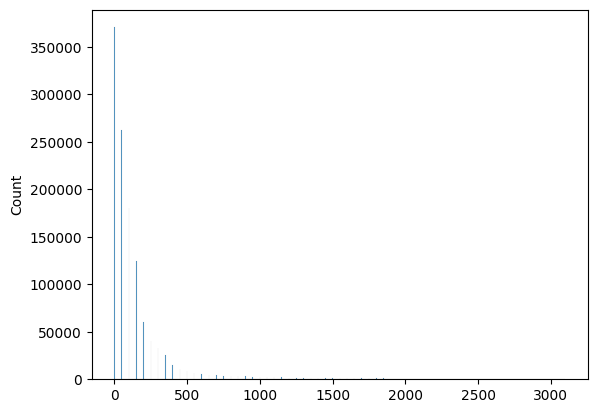

In [ ]:
sns.histplot((df.WhiteElo-df.BlackElo).abs() // 50 * 50)

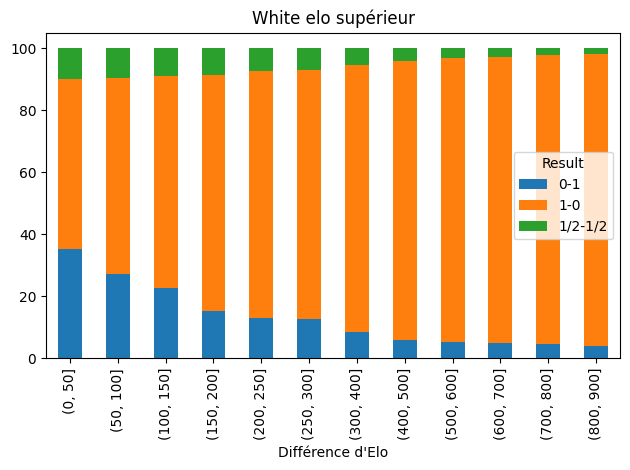

In [ ]:
# Calcul de la différence d'Elo
df['Elo_diff'] = df['WhiteElo'] - df['BlackElo']

elo_diff_brackets = ['<50',
                     '50-100', '100-150', '150-200', '200-250', '250-300']

bins = [0, 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900]
df['Elo_diff_bracket'] = pd.cut(df['Elo_diff'], bins=bins)

for i in range(400,901,100):
    elo_diff_brackets.append(f'{i-100}-{i}')

df['Black_higher'] = df['BlackElo'] > df['WhiteElo']

# groupby et compte seulement si WhiteElo > BlackElo
white_higher = df[df['Black_higher']==False].groupby(['Elo_diff_bracket','Result'])['Result'].count()

# Total
white_total = df[df['Black_higher']==False].groupby('Elo_diff_bracket')['Result'].count()

# Pourcentages
white_percents = white_higher/white_total * 100

# Deux plot distincts
fig, ax = plt.subplots(1, 1)

white_percents.unstack().plot(kind='bar', stacked=True, ax=ax)

ax.set_title("White elo supérieur")
ax.set_xlabel("Différence d'Elo")

plt.tight_layout()
plt.show()

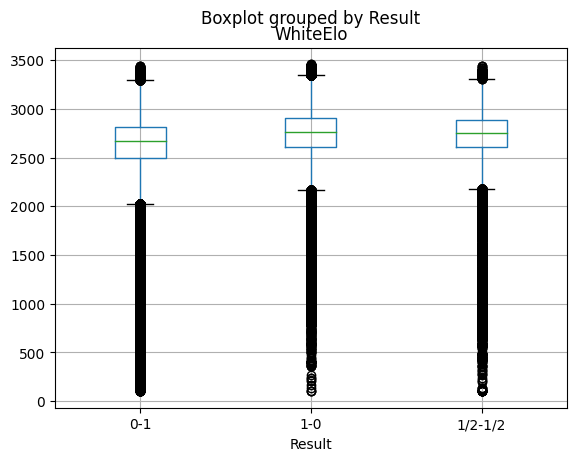

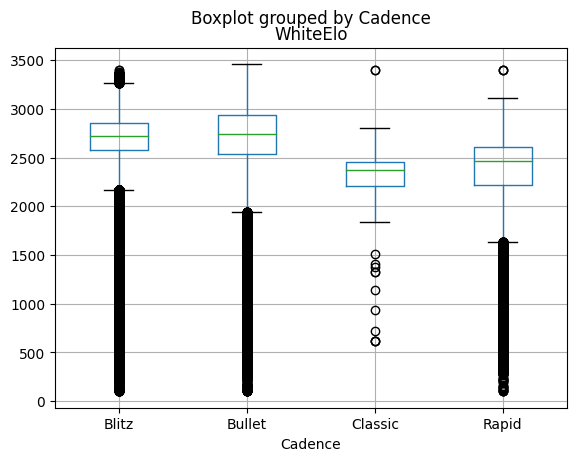

In [ ]:
# Boxplot entre l'Elo et le résultat
df.boxplot(column=['WhiteElo'], by='Result')
plt.show()

# Boxplot entre l'Elo et le style de jeu
df.boxplot(column=['WhiteElo'], by='Cadence')
plt.show()

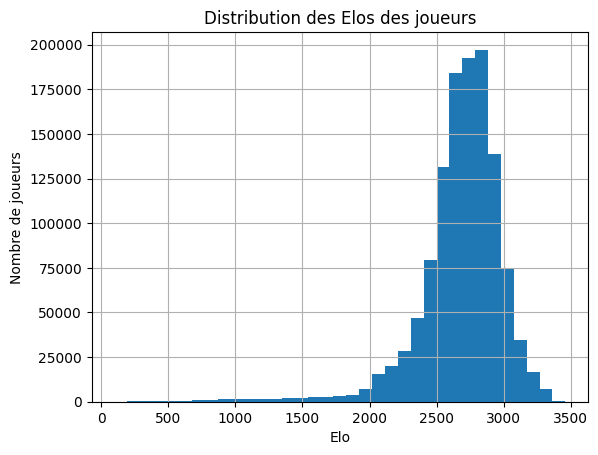

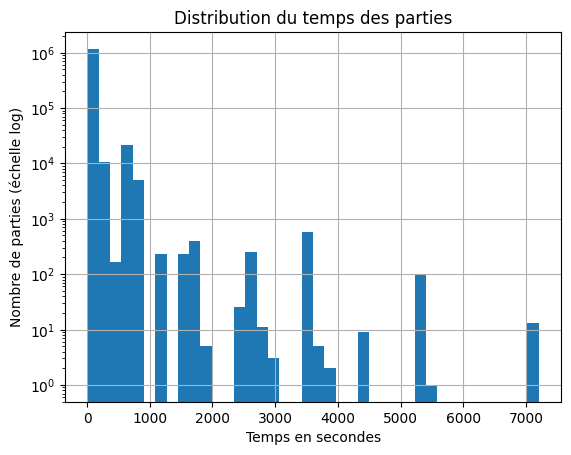

In [ ]:
# Histogramme des Elos
df[['WhiteElo']].hist(bins=35)

plt.title("Distribution des Elos des joueurs")
plt.xlabel("Elo")
plt.ylabel("Nombre de joueurs")

plt.show()

# Histogramme du temps de réflexion en échelle log
df['Time'].hist(bins=40, log=True)

plt.title("Distribution du temps des parties")
plt.xlabel("Temps en secondes")
plt.ylabel("Nombre de parties (échelle log)")

plt.show()

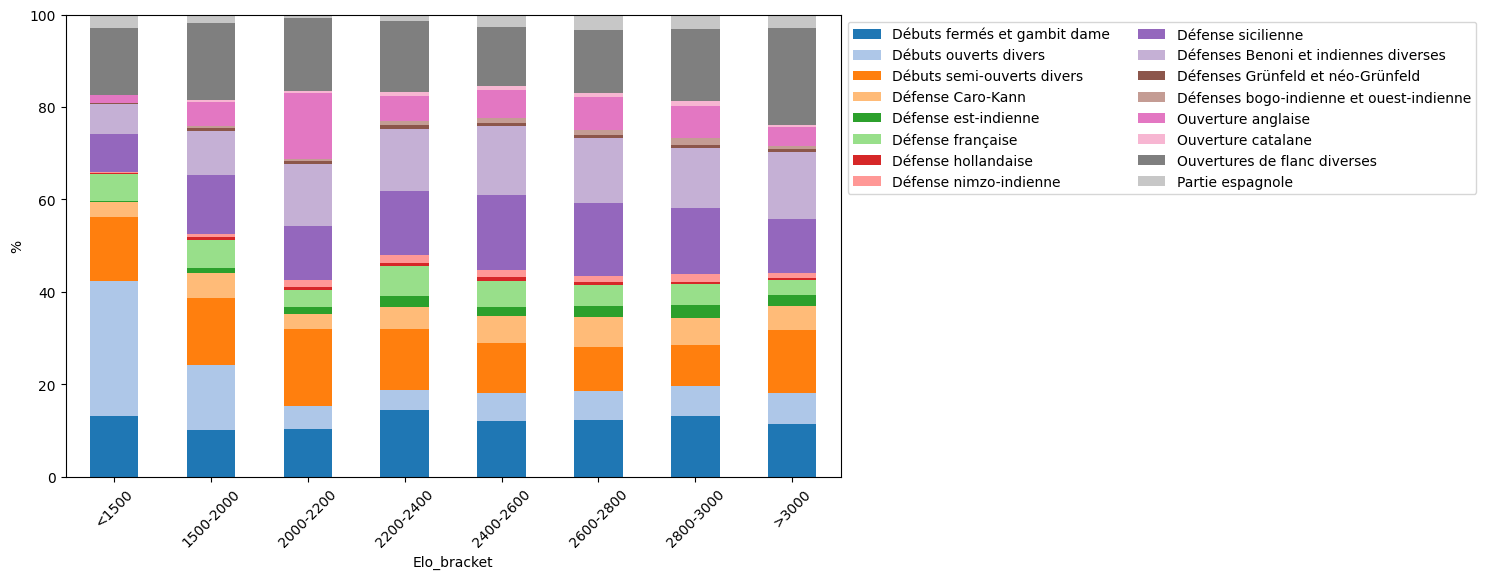

In [ ]:
# Définition des fourchettes d'Elo
elo_brackets = ['<1500', '1500-2000', '2000-2200', '2200-2400', '2400-2600',
                '2600-2800', '2800-3000', '>3000']

# Ajout d'une colonne Elo moyen et Elo_bracket
df['Elo_moyen'] = (df['WhiteElo'] + df['BlackElo'])/2
df['Elo_bracket'] = pd.cut(df['Elo_moyen'], bins = [0, 1500, 2000, 2200, 2400, 2600, 2800, 3000, 10000], labels=elo_brackets)

# Définition d'une color map avec 20 couleurs
num_openings = 20
color_map = plt.cm.tab20(np.linspace(0, 1, num_openings))

# Comptage des ouvertures par bracket Elo moyen
opening_freqs = (df.groupby(['Elo_bracket','Opening'])['Elo_moyen']
                   .count() / df.groupby('Elo_bracket')['Elo_moyen'].count()) * 100

# Reshape en dataframe pour plotting
opening_freqs = opening_freqs.unstack(level=1)

# Diagramme en barres empilées par ouverture
opening_freqs.plot(kind='bar', stacked=True, figsize=(10,6), color=color_map)
plt.xticks(rotation=45)
plt.ylabel("%")
plt.ylim(0,100)
# Légende sur 2 lignes
leg = plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2)

# Marge autour du graphique
plt.margins(0.2)

plt.show()

## Modelling (+Encoding)
This section discusses feature engineering and encoding of categorical features for model training. The following transformations are applied:

- TargetEncoding for categorical columns like 'Event', 'ECO', 'White', 'Black'

- OneHotEncoding for 'ECOLetter', 'Opening'

- OrdinalEncoding for ordinal column 'DateYear'

- Custom transformations like encoding time features using trigonometric functions

- MinMaxScaler for numerical columns like 'WhiteElo', 'BlackElo', 'Time', 'Increment'

The preprocessed data is transformed and stored in a new dataframe with encoded features.

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.random_projection import SparseRandomProjection
from sklearn.svm import SVC

from category_encoders import TargetEncoder

from warnings import simplefilter

# Ignore ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/chess/df_modif.csv", index_col=0)

In [ ]:
df.Result.value_counts()

1-0        577014
0-1        517955
1/2-1/2    107984
Name: Result, dtype: int64

In [ ]:
le = LabelEncoder()
df.Result = le.fit_transform(df.Result)
df.head()

,Event,StartTime,White,Black,WhiteElo,BlackElo,ECO,Result,Time,Increment,DateYear,DateMonth,DateDay,ECOLetter,Opening,Cadence
0,Live Chess,18.837222,1977Ivan,TimAina,2733,2771,A45,0,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
1,Live Chess,18.778333,TimAina,1977Ivan,2763,2759,A41,0,180,0,2023,12,21,A,Défenses Benoni et indiennes diverses,Blitz
2,Live Chess,11.588889,1stSecond,deathadder96,2814,2809,A13,0,180,0,2023,12,30,A,Ouverture anglaise,Blitz
3,Live Chess,11.480556,deathadder96,1stSecond,2801,2822,A67,0,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz
4,Live Chess,11.482500,1stSecond,deathadder96,2814,2809,A40,0,180,0,2023,12,30,A,Défenses Benoni et indiennes diverses,Blitz


In [ ]:
le.classes_

array(['0-1', '1-0', '1/2-1/2'], dtype=object)

### Naive model
The Elo difference is used to calculate win probabilities according to tables available online. We will use such tables to create a very naive initial model that will not even predict draw results.

In [ ]:
prob_table = {-800: 0.99, -750: 1.32, -700: 1.75, -650: 2.32, -600: 3.07, -550: 4.05, -500: 5.32, -450: 6.98, -400: 9.09, -350: 11.77, -300: 15.1, -250: 19.17, -200: 24.03, -150: 29.66, -100: 35.99, -50: 42.85, 0: 50, 50: 57.15, 100: 64.01, 150: 70.34, 200: 75.97, 250: 80.83, 300: 84.9, 350: 88.23, 400: 90.91, 450: 93.02, 500: 94.68, 550: 95.95, 600: 96.93, 650: 97.68, 700: 98.25, 750: 98.68, 800: 99.01}

In [ ]:
X = df[['WhiteElo','BlackElo']]
y = df['Result']

X = X.values
y = y.values

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 )

preds = []

for x, y in zip(X_test, y_test):
  elo1 = x[0]
  elo2 = x[1]

  diff = elo1 - elo2
  if diff > 800:
    diff = 800
  elif diff < -800:
    diff = -800
  diff = int(diff/50) * 50

  prob = prob_table[diff]/100

  pred = np.random.binomial(1, prob)
  preds.append(pred)
correct = 0
incorrect = 0

for i in range(len(X_test)):

  pred = preds[i]
  true_label = y_test[i]

  if pred == true_label:
    correct += 1
  else:
    incorrect += 1
total = correct + incorrect
print(f"Correct predictions: {correct/total}")
print(f"Incorrect predictions: {incorrect/total}")

Correct predictions: 0.5432331217709723
Incorrect predictions: 0.4567668782290277


###Others
Various classifiers are trained on the encoded data - Logistic Regression, Gradient Boosting, HistGradientBoosting, SVC, PassiveAggressive. We tried fitting a Random Forest but it was too time consuming with Cross Validation.

Models are evaluated using cross-validation and results are stored. Logistic Regression shows the best performance with an accuracy of ~65% on the test set.

It is further evaluated on a separate evaluation set.

Confusion matrix and classification report are used to analyze model performance on different classes. Model performs well on wins but struggles with draws.

In [ ]:
n_cv_folds = 5
results = deque()


def evaluate_model_and_store(name, pipe, X=df.drop(axis=1, columns="Result"), y=df.Result):
    result = cross_val_score(
        pipe,
        X,
        y,
        cv=n_cv_folds,
    )

    results.append({"model": name,"acc_cv": result})

In [ ]:
# Function to encode time features using trigonometric functions
def encode_time_features(df):
    df['StartTime_hour_sin'] = np.sin(2 * np.pi * df['StartTime'] / 24)
    df['StartTime_hour_cos'] = np.cos(2 * np.pi * df['StartTime'] / 24)
    df['DateDay_sin'] = np.sin(2 * np.pi * df['DateDay'] / 31)  # Assuming max days in a month is 31
    df['DateDay_cos'] = np.cos(2 * np.pi * df['DateDay'] / 31)
    df['DateMonth_sin'] = np.sin(2 * np.pi * df['DateMonth'] / 12)
    df['DateMonth_cos'] = np.cos(2 * np.pi * df['DateMonth'] / 12)
    return df[['StartTime_hour_sin', 'StartTime_hour_cos', 'DateDay_sin', 'DateDay_cos', 'DateMonth_sin', 'DateMonth_cos']]

time_feature_names_out = encode_time_features(df.loc[0:1,].copy()).columns.to_list()

In [ ]:
# name_encoder = Pipeline(steps=[
#     ('onehot', OneHotEncoder(sparse_output=True, dtype=int, handle_unknown='ignore')),
#     ('proj', SparseRandomProjection())
# ]) # perf ~ TargetEncoder()

name_encoder = TargetEncoder()

# name_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1) # (worst perf)

preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc_', TargetEncoder(), ['Event', 'ECO']),
         ('ord', OrdinalEncoder(), ['DateYear']),
          ('cyclic', FunctionTransformer(encode_time_features, validate=False, feature_names_out=lambda x, y: time_feature_names_out), ['StartTime', 'DateDay', 'DateMonth']),
           ('onehot', OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore'), ['ECOLetter', 'Opening', 'Cadence']),
            ('name_enc_', name_encoder, ['White', 'Black']),
             ('minmax', MinMaxScaler(), ['WhiteElo', 'BlackElo', "Time", "Increment"])
        ],
    remainder='passthrough'
)

data_encoded = preprocessor.fit_transform(X=df, y=df.Result)
df_encoded = pd.DataFrame(data_encoded, columns=preprocessor.get_feature_names_out())
# df_encoded = pd.DataFrame.sparse.from_spmatrix(data_encoded)
df_encoded.head()

,target_enc___Event,target_enc___ECO,ord__DateYear,cyclic__StartTime_hour_sin,cyclic__StartTime_hour_cos,cyclic__DateDay_sin,cyclic__DateDay_cos,cyclic__DateMonth_sin,cyclic__DateMonth_cos,onehot__ECOLetter_A,...,onehot__Cadence_Bullet,onehot__Cadence_Classic,onehot__Cadence_Rapid,name_enc___White,name_enc___Black,minmax__WhiteElo,minmax__BlackElo,minmax__Time,minmax__Increment,remainder__Result
0,0.659727,0.631652,1.0,-0.976075,0.217433,-0.897805,-0.440394,-2.449294e-16,1.0,1.0,...,0.0,0.0,0.0,0.821917,0.673611,0.783864,0.796125,0.023644,0.0,0.0
1,0.659727,0.608625,1.0,-0.979311,0.202360,-0.897805,-0.440394,-2.449294e-16,1.0,1.0,...,0.0,0.0,0.0,0.605263,0.443663,0.792795,0.792548,0.023644,0.0,0.0
2,0.659727,0.674481,1.0,0.107421,-0.994214,-0.201299,0.979530,-2.449294e-16,1.0,1.0,...,0.0,0.0,0.0,0.742347,0.752577,0.807979,0.807452,0.023644,0.0,0.0
3,0.659727,0.648968,1.0,0.135571,-0.990768,-0.201299,0.979530,-2.449294e-16,1.0,1.0,...,0.0,0.0,0.0,0.610837,0.601504,0.804108,0.811326,0.023644,0.0,0.0
4,0.659727,0.628462,1.0,0.135067,-0.990836,-0.201299,0.979530,-2.449294e-16,1.0,1.0,...,0.0,0.0,0.0,0.742347,0.752577,0.807979,0.807452,0.023644,0.0,0.0


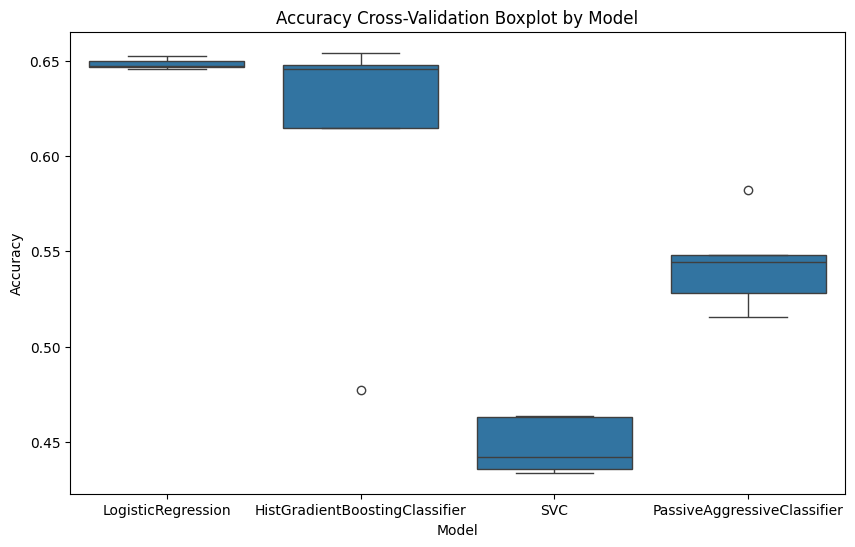

In [ ]:
models = [LogisticRegression(),
          HistGradientBoostingClassifier(),
          SVC(max_iter=100),
          PassiveAggressiveClassifier()
          ]


for model in models:
  pipeline = Pipeline([("prep", preprocessor), ("mod", model)])
  evaluate_model_and_store(model.__class__.__name__, pipeline)

df_expanded = pd.DataFrame(results, columns=results[0].keys()).explode("acc_cv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='acc_cv', data=df_expanded)
plt.title('Accuracy Cross-Validation Boxplot by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Result", axis=1), df.Result, test_size=.2, stratify=df.Result)
pipeline = Pipeline([("prep", preprocessor), ("mod", LogisticRegression())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_enc_',
                                                  TargetEncoder(),
                                                  ['Event', 'ECO']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['DateYear']),
                                                 ('cyclic',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x7d057f3f4940>,
                                                                      func=<function encode_time_features at 0x7d057f3f4a60>),
                                                  ['StartTime', 'DateDay',
                                                   'DateMonth']),
                                                 ('onehot',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['ECOLetter', 'Opening',
                                                   'Cadence']),
                                                 ('name_enc_', TargetEncoder(),
                                                  ['White', 'Black']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['WhiteElo', 'BlackElo',
                                                   'Time', 'Increment'])])),
                ('mod', LogisticRegression())])

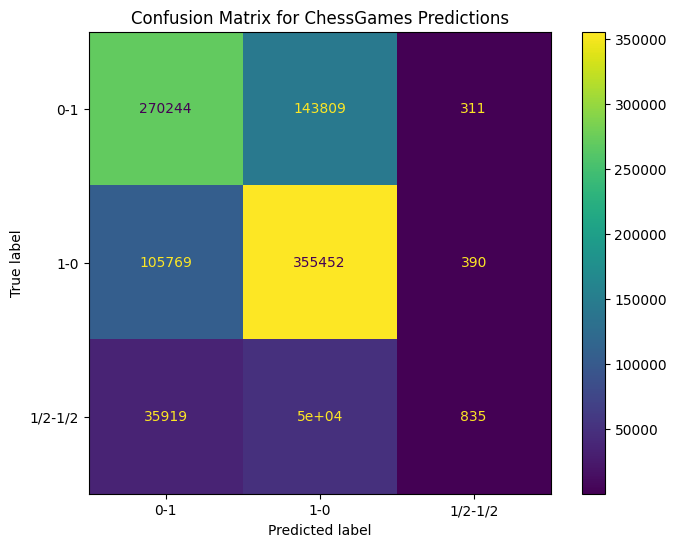

In [ ]:
# Make predictions on the training data using the pipeline
y_pred = pipeline.predict(X_train)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Create a figure and axis object for plotting
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# Create a ConfusionMatrixDisplay object for visualization
display = ConfusionMatrixDisplay(conf_matrix, display_labels=le.classes_)

# Set the plot title using the axis object
ax.set(title='Confusion Matrix for ChessGames Predictions')

# Plot the confusion matrix, passing the axis object for customization
display.plot(ax=ax)


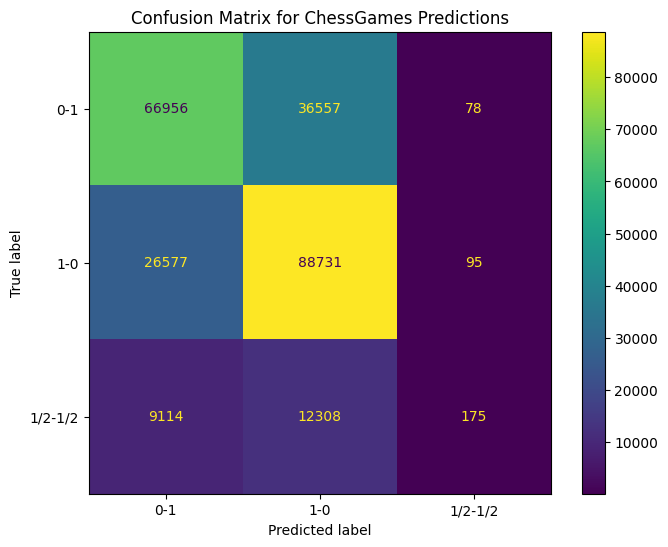

In [ ]:
y_pred = pipeline.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix, display_labels=le.classes_)

ax.set(title='Confusion Matrix for ChessGames Predictions')

display.plot(ax=ax);

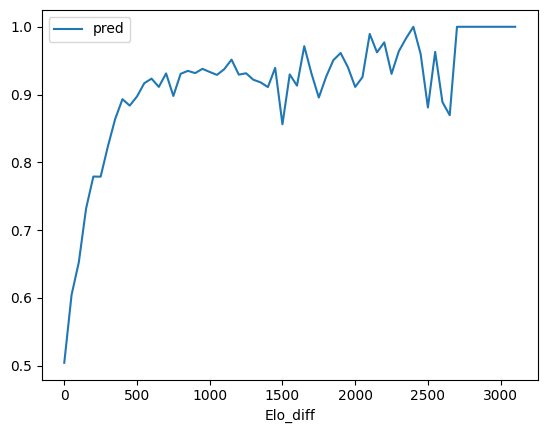

In [ ]:
acc_by_ELO_diff = pd.DataFrame({"Elo_diff": (X_test.WhiteElo-X_test.BlackElo).abs() // 50 * 50, "pred": y_pred == y_test}).groupby("Elo_diff").mean()
acc_by_ELO_diff.plot()
plt.show()

In [ ]:
acc_by_ELO_diff = pd.DataFrame({"Elo_diff": (X_test.WhiteElo-X_test.BlackElo).abs() // 50 * 50, "pred": y_pred == y_test})
acc_by_ELO_diff

,Elo_diff,pred
612436,150,True
750703,900,True
1049794,2000,True
842277,0,False
542544,50,False
...,...,...
1236140,100,True
1162844,500,True
476987,150,True
969019,0,True


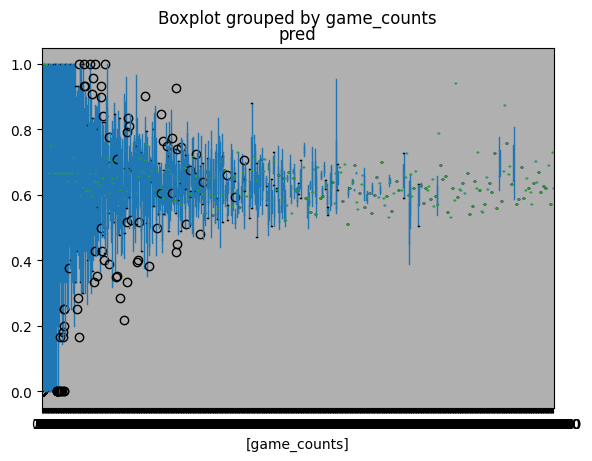

In [ ]:
# Create DataFrame to calculate accuracy by white player
acc_by_white = pd.DataFrame({"White": X_test.White, "pred": y_pred == y_test}).groupby("White").mean()

# Join with counts of games played by white player from training data
acc_by_white = acc_by_white.join(X_train.White.value_counts(), how="left").fillna(0)

# Rename column for clarity
acc_by_white.rename(columns={"White": "game_counts"}, inplace=True)

# Generate boxplot of accuracy grouped by game counts
acc_by_white.boxplot(by="game_counts")

# Display the plot
plt.show()


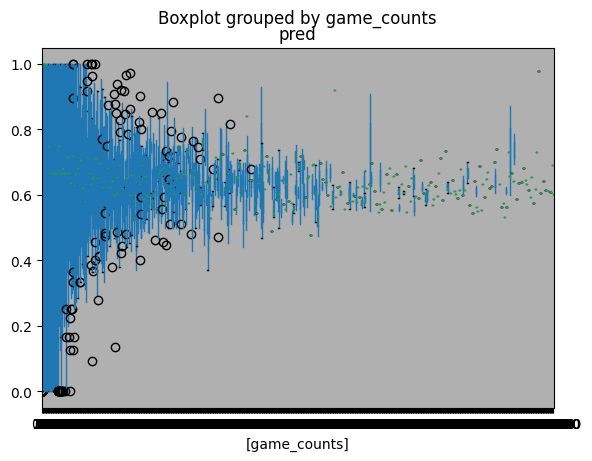

In [ ]:
acc_by_black = pd.DataFrame({"Black": X_test.Black, "pred": y_pred == y_test}).groupby("Black").mean()
acc_by_black = acc_by_black.join(X_train.Black.value_counts(), how="left").fillna(0)
acc_by_black.rename(columns={"Black": "game_counts"}, inplace=True)
acc_by_black
acc_by_black.boxplot(by="game_counts")
plt.show()

In [ ]:
acc_by_cadence = pd.DataFrame({"Cadence": X_test.Cadence, "pred": y_pred == y_test}).groupby("Cadence").mean()
acc_by_cadence = acc_by_cadence.join(X_train.Cadence.value_counts(), how="left").fillna(0)
acc_by_cadence.rename(columns={"Cadence": "game_counts"}, inplace=True)
acc_by_cadence

,pred,game_counts
Cadence,,
Blitz,0.634718,663792
Bullet,0.678785,276090
Classic,0.809524,109
Rapid,0.651116,22371


In [ ]:
acc_by_ECOLetter = pd.DataFrame({"ECOLetter": X_test.ECOLetter, "pred": y_pred == y_test}).groupby("ECOLetter").mean()
acc_by_ECOLetter = acc_by_ECOLetter.join(X_train.ECOLetter.value_counts(), how="left").fillna(0)
acc_by_ECOLetter.rename(columns={"ECOLetter": "game_counts"}, inplace=True)
acc_by_ECOLetter

,pred,game_counts
ECOLetter,,
A,0.652853,346736
B,0.651812,299492
C,0.640226,135114
D,0.635528,125523
E,0.641621,55497


### Embedding (⚠︎ discarded)
This section introduces a neural network to learn embeddings from player IDs for potentially improved predictions compared to one-hot encodings. An model takes ID inputs and outputs concatenated learned embeddings. A transformer implements this model as a scikit-learn transformer for usage in the overall modeling pipeline. However, there were some challenges faced and the approach was not fully realized due to time constraints.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define simple embedding neural network
class EmbeddingNN(nn.Module):
    def __init__(self, white_input_dim, black_input_dim, embedding_dim, output_dim):
        super(EmbeddingNN, self).__init__()
        self.white_input_dim = white_input_dim
        self.embedding_white = nn.Embedding(white_input_dim, embedding_dim)
        self.embedding_black = nn.Embedding(black_input_dim, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, x):
        white_embed = self.embedding_white(x[:, :self.white_input_dim])
        black_embed = self.embedding_black(x[:, self.white_input_dim:])
        x = torch.cat((white_embed, black_embed), dim=1)
        return F.softmax(self.fc(x), dim=-1)

# Custom transformer for player embedding
class PlayerEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_dim, output_dim):
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.white_input_dim = X_train.White.nunique()
        self.model = EmbeddingNN(white_input_dim=self.white_input_dim, black_input_dim=X_train.Black.nunique(), embedding_dim=embedding_dim, output_dim=output_dim)
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters())

    def fit(self, X, y=None):
        X_tensor = torch.Tensor(X, dtype=torch.long)
        y_tensor = torch.Tensor(y, dtype=torch.long)

        # Training loop
        for epoch in range(100):
            self.optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.loss_function(outputs, y_tensor)
            loss.backward()
            self.optimizer.step()

        return self

    def transform(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.long)
            embeddings = self.model.embedding_white(X_tensor[:, :self.white_input_dim]).numpy(), self.model.embedding_black(X_tensor[:, self.white_input_dim:]).numpy()
        return embeddings

name_embedding = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')),
     ('embedding', PlayerEmbeddingTransformer(embedding_dim=10, output_dim=3))
])

In [ ]:
%%shell
jupyter nbconvert --to html /content/ChessGaMes_Predictions.ipynb

[NbConvertApp] Converting notebook /content/ChessGaMes_Predictions.ipynb to html
[NbConvertApp] Writing 1488365 bytes to /content/ChessGaMes_Predictions.html
